chexnet (rajkupar): horizontal flipping
yao: random rotations from -15 to 15 degrees
    scaled between 80 and 120%
    translation in 4 directions by 25 pixels
baltruschat: random rotations by +- 7 degrees
    horizontal flipping
    aspect ration variation between 3:4 and 4:3
    patch sampling between 8 and 100% of the original image
    weiss ja nicht: rescaling to 256 / 480 and then center crop
yan: horizontal flipping
    cropping 448 out of 512: per corner and middle
shen: flipping
    adjusting brightness and contrast
shamrat: rotate up to 90 degrees
    translate
    vertical flip

1. Horizontal Flipping
2. Vertical Flipping
3. Rotations
4. Translations (Not because Cropping)
5. Cropping => First resize to 256, then crop 224

IMAGE
- Color space not really feasible -> Maybe it is, since we transform it to 3d images -> Still not because evaluation data not
6. Adjusting brightness and contrast
7. Kernel filters

For visualization: Choose always the n-th image -> Also a validation that labels fit


In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm


In [3]:
csv_file_path = '../DL_for_Hin_Chest_X_Ray/Data_Entry_2017_filtered_2.csv'
# csv_file_path = '../DL_for_Hin_Chest_X_Ray/HIN_archive/Data_Entry_2017.csv'
df = pd.read_csv(csv_file_path)

IMAGE_DIR = "../DL_for_Hin_Chest_X_Ray/HIN_archive/images/"
ALL_LABELS = sorted(df["Finding Labels"].str.split("|").explode().unique())
ALL_LABELS_WITHOUT_NO = [l for l in ALL_LABELS if l != "No Finding"]
NUMBER_CLASSES = len(ALL_LABELS)

def preprocess_image(file_path, image_size):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, (image_size, image_size))
    return image

def prepare_data(df, image_size, image_dir=IMAGE_DIR):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)

            current_label = np.zeros(NUMBER_CLASSES, dtype=int)
        
            if row["Finding Labels"] != "No Finding":
                indices = [i for i, label in enumerate(ALL_LABELS_WITHOUT_NO) if label in sorted(row["Finding Labels"].split("|"))]
                for idx in indices:
                    if 0 <= idx < NUMBER_CLASSES:
                        current_label[idx] = 1
            else:
                current_label[NUMBER_CLASSES - 1] = 1
            labels.append(current_label)
    
    images = np.array(images).reshape(-1, image_size, image_size)
    images = np.repeat(images[..., np.newaxis], 3, axis=-1) #rgb
    
    labels = np.array(labels)
    
    return images, labels

In [4]:
DATA_PATH = 'augmentation_data'
NUMBER_OF_IMAGES = 5000
IMAGE_SIZE = 224
IMAGE_CENTER = (IMAGE_SIZE // 2, IMAGE_SIZE // 2)

In [5]:
images, labels = prepare_data(df[:NUMBER_OF_IMAGES], IMAGE_SIZE)
images_test, labels_test = prepare_data(df[-2000:], IMAGE_SIZE)

with open(f"{DATA_PATH}/images_clean.pkl", "wb") as file:
    pickle.dump(images, file)
with open(f"{DATA_PATH}/labels_clean.pkl", "wb") as file:
    pickle.dump(labels, file)
with open(f"{DATA_PATH}/images_test.pkl", "wb") as file:
    pickle.dump(images_test, file)
with open(f"{DATA_PATH}/labels_test.pkl", "wb") as file:
    pickle.dump(labels_test, file)

100%|██████████| 2000/2000 [00:30<00:00, 66.29it/s]


In [78]:
with open(f"{DATA_PATH}/images_clean.pkl", "rb") as file:
    images_clean = pickle.load(file)
with open(f"{DATA_PATH}/labels_clean.pkl", "rb") as file:
    labels_clean = pickle.load(file)
    
print(images_clean.shape)
print(labels_clean.shape)

(5000, 224, 224, 3)
(5000, 4)


In [86]:
# adjusted_images, adjusted_labels = prepare_data_rotation(images_clean, labels_clean)
adjusted_images, adjusted_labels = prepare_data_crop(df[:5000])

print(adjusted_images.shape)
print(adjusted_labels.shape)

100%|██████████| 5000/5000 [00:00<00:00, 1134822.51it/s]


(25000, 224, 224, 3)
(25000, 4)


In [87]:
with open(f"{DATA_PATH}/images_crop.pkl", "wb") as file:
    pickle.dump(adjusted_images, file)
with open(f"{DATA_PATH}/labels_crop.pkl", "wb") as file:
    pickle.dump(adjusted_labels, file)

In [32]:
adjusted_image = images_clean[6]
translation_matrix = np.float32([[1, 0, 16], [0, 1, 0]])
adjusted_image = cv2.warpAffine(adjusted_image, translation_matrix, (IMAGE_SIZE, IMAGE_SIZE))
cv2.imwrite(f"augmentation_images/translation.png", adjusted_image)
cv2.imwrite(f"TEST.png", adjusted_image)

True

In [22]:
def prepare_data_horizontal_flip(clean_images, clean_labels):
    new_images = []
    
    for clean_image in tqdm(clean_images):
        rotated_image = cv2.flip(clean_image, 1)
        new_images.append(rotated_image)
        
    new_images = np.array(new_images).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
    all_images = np.concatenate((clean_images, new_images), axis=0)
    all_labels = np.concatenate((clean_labels, clean_labels), axis=0)
            
    return all_images, all_labels

In [13]:
def prepare_data_vertical_flip(clean_images, clean_labels):
    new_images = []
    
    for clean_image in tqdm(clean_images):
        rotated_image = cv2.flip(clean_image, 0)
        new_images.append(rotated_image)
        
    new_images = np.array(new_images).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
    all_images = np.concatenate((clean_images, new_images), axis=0)
    all_labels = np.concatenate((clean_labels, clean_labels), axis=0)
            
    return all_images, all_labels

In [54]:
def prepare_data_rotation(clean_images, clean_labels):
    new_images = []
    
    for clean_image in tqdm(clean_images): 
        angle = np.random.uniform(-30, -15)
        rotation_matrix = cv2.getRotationMatrix2D(IMAGE_CENTER, angle, 1.0)
        rotated_image = cv2.warpAffine(clean_image, rotation_matrix, (IMAGE_SIZE, IMAGE_SIZE))
        new_images.append(rotated_image)
    for clean_image in tqdm(clean_images): 
        angle = np.random.uniform(15, 30)
        rotation_matrix = cv2.getRotationMatrix2D(IMAGE_CENTER, angle, 1.0)
        rotated_image = cv2.warpAffine(clean_image, rotation_matrix, (IMAGE_SIZE, IMAGE_SIZE))
        new_images.append(rotated_image)
        
    new_images = np.array(new_images).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
    all_images = np.concatenate((clean_images, new_images), axis=0)
    all_labels = np.concatenate((clean_labels, clean_labels, clean_labels), axis=0)
            
    return all_images, all_labels

In [5]:
# deprecated and not used

# def prepare_images_translation(clean_images):
#     images = []
#     
#     for clean_image in tqdm(clean_images):
#             
#         dx = np.random.uniform(-30, 30)
#         dy = np.random.uniform(-30, 30)
#         translation_matrix = np.float32([[1, 0, dx], [0, 1, dy]])
#         translated_image = cv2.warpAffine(clean_image, translation_matrix, (IMAGE_SIZE, IMAGE_SIZE))
#         
#         images.append(translated_image)
#             
#     return np.array(images).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)

In [76]:
def prepare_data_crop(df):
    
    clean_images, clean_labels = prepare_data(df, 256)
    new_images = []
    
    for clean_image in tqdm(clean_images):
        new_images.append(cv2.resize(clean_image, (224, 224)))
    for clean_image in tqdm(clean_images):
        new_images.append(clean_image[0:224, 0:224])
    for clean_image in tqdm(clean_images):
        new_images.append(clean_image[32:256, 0:224])
    for clean_image in tqdm(clean_images):
        new_images.append(clean_image[0:224, 32:256])
    for clean_image in tqdm(clean_images):
        new_images.append(clean_image[32:256, 32:256])
    # Leaving out the middle crop

    # for clean_image in tqdm(clean_images):
    #     new_images.append(clean_image[16:240, 16:240])
        
    new_images = np.array(new_images).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3) 
    all_images = new_images
    all_labels = np.concatenate((clean_labels, clean_labels, clean_labels, clean_labels, clean_labels), axis=0)            
    
    return all_images, all_labels

100%|██████████| 50/50 [00:00<00:00, 794375.76it/s]


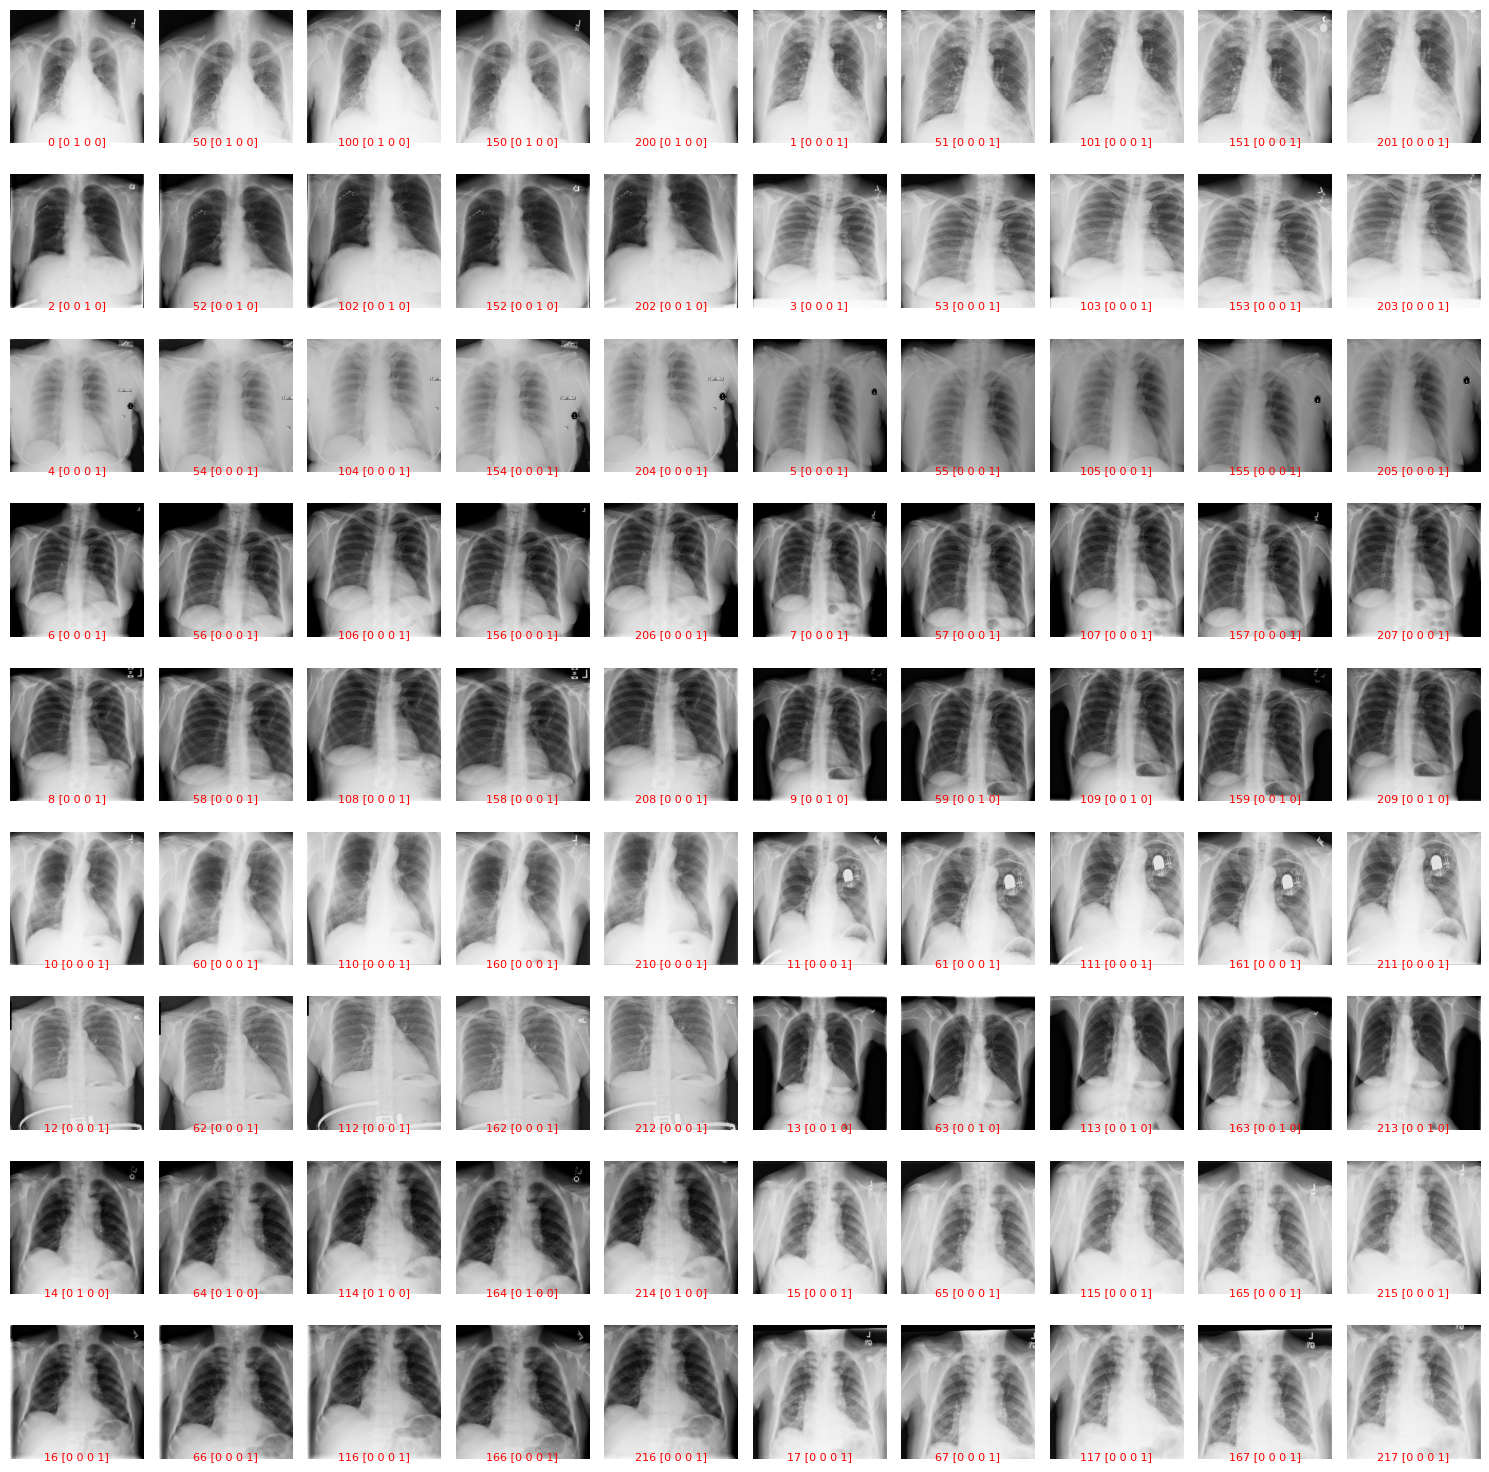

In [77]:
fig, axes = plt.subplots(9, 10, figsize=(15, 15))
axes = axes.ravel()
    
# images_to_show, labels_to_show = prepare_data_rotation(images_clean[:50], labels_clean[:50])
images_to_show, labels_to_show = prepare_data_crop(df[:50])

counter = 0
for i in range(0, 90, 5):

    axes[i].imshow(images_to_show[counter])  
    axes[i].axis('off')
    axes[i].text(0.5, 0.05, str(counter) + " " + str(labels_to_show[counter]) , color='red', ha='center', va='top', fontsize=8, transform=axes[i].transAxes)
    
    axes[i + 1].imshow(images_to_show[counter + 50])  
    axes[i + 1].axis('off')
    axes[i + 1].text(0.5, 0.05, str(counter + 50) + " " + str(labels_to_show[counter + 50]) , color='red', ha='center', va='top', fontsize=8, transform=axes[i + 1].transAxes)
    
    axes[i + 2].imshow(images_to_show[counter + 100])  
    axes[i + 2].axis('off')
    axes[i + 2].text(0.5, 0.05, str(counter + 100) + " " + str(labels_to_show[counter + 100]) , color='red', ha='center', va='top', fontsize=8, transform=axes[i + 2].transAxes)
    
    axes[i + 3].imshow(images_to_show[counter + 150])  
    axes[i + 3].axis('off')
    axes[i + 3].text(0.5, 0.05, str(counter + 150) + " " + str(labels_to_show[counter + 150]) , color='red', ha='center', va='top', fontsize=8, transform=axes[i + 3].transAxes)
    
    axes[i + 4].imshow(images_to_show[counter + 200])  
    axes[i + 4].axis('off')
    axes[i + 4].text(0.5, 0.05, str(counter + 200) + " " + str(labels_to_show[counter + 200]) , color='red', ha='center', va='top', fontsize=8, transform=axes[i + 4].transAxes)
    
    counter += 1

plt.tight_layout()
plt.show()

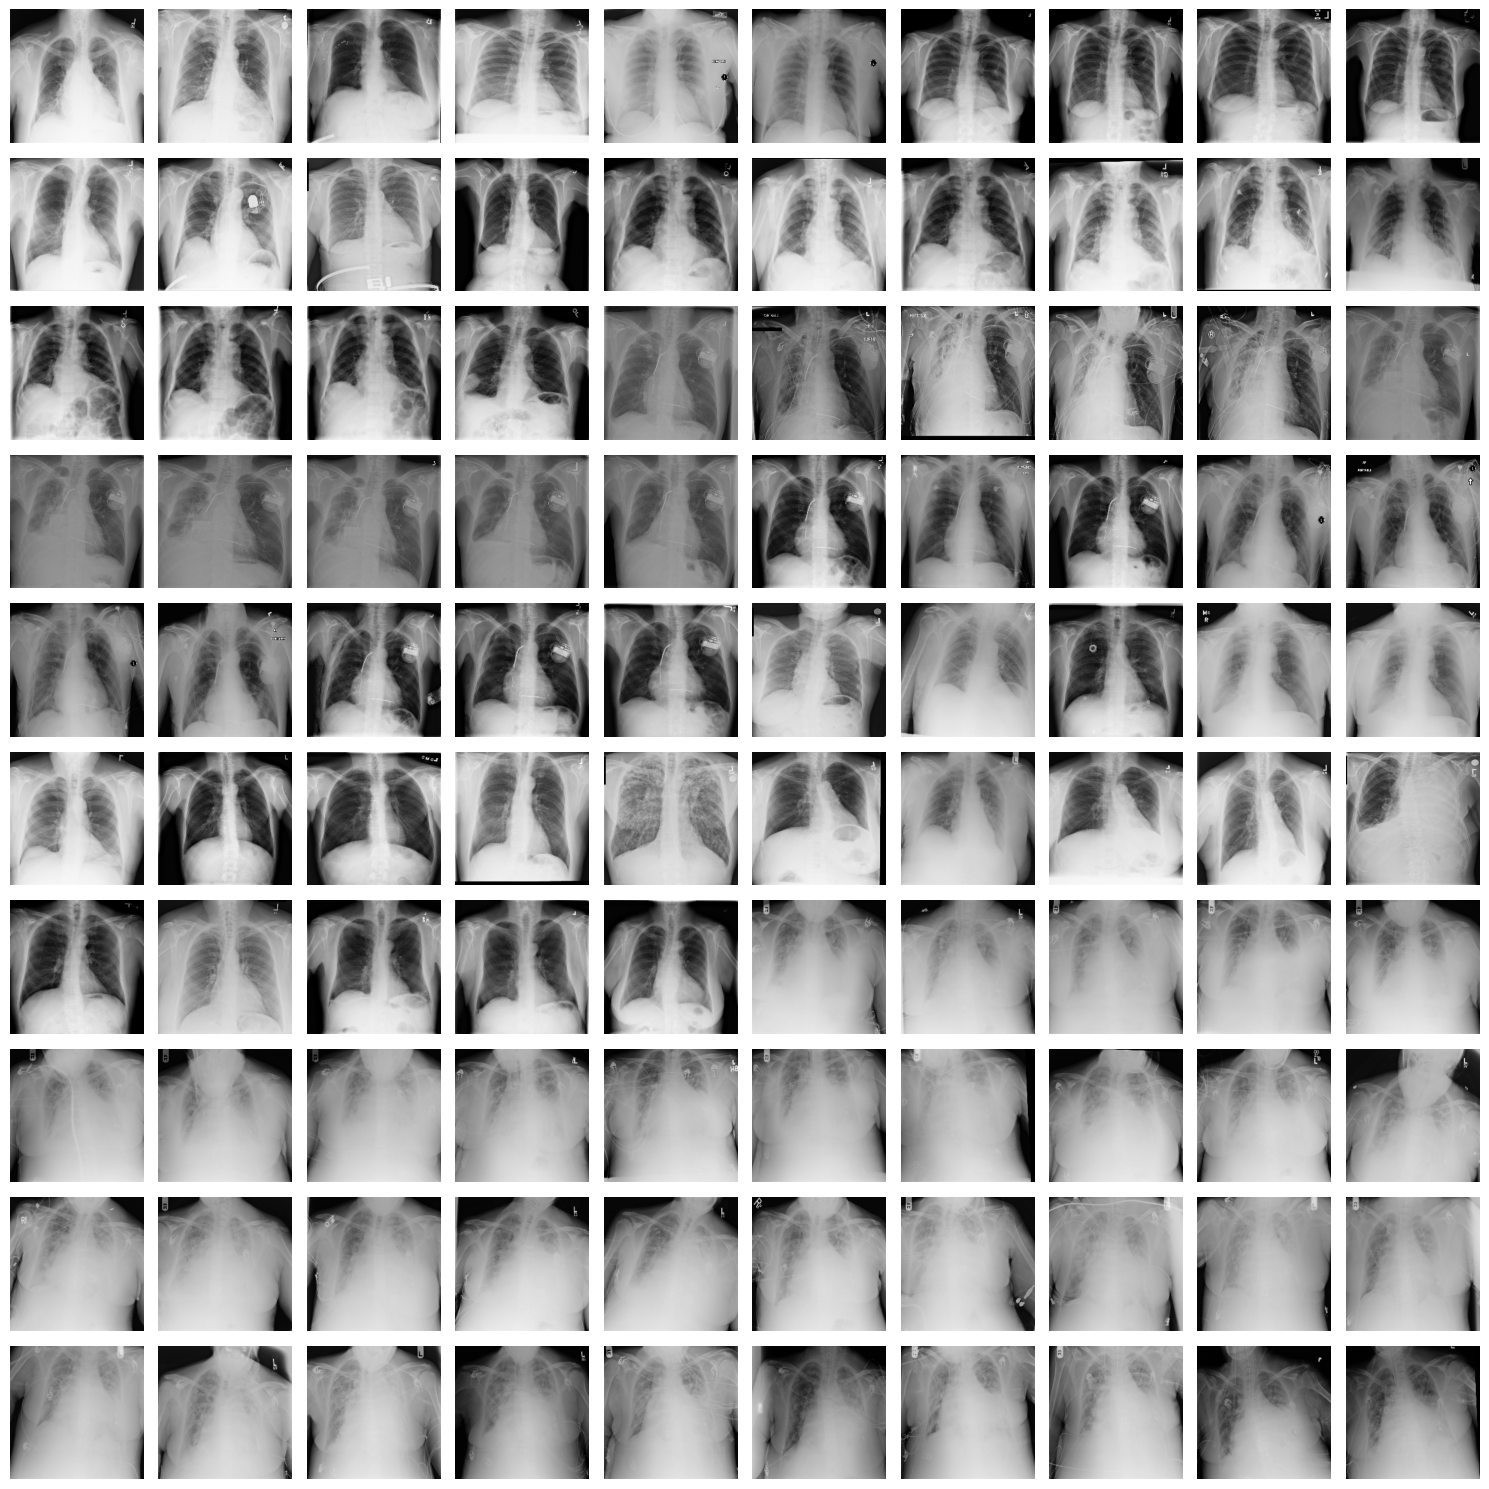

In [20]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
axes = axes.ravel()
    
    
images_to_show = images_clean[:100]

# Loop through and display images
for i in range(100):
    axes[i].imshow(images_to_show[i])  # Display the image
    axes[i].axis('off')  # Hide the axes

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()